In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [2]:
def collect_experiment_to_df(fpath="expt_logs/"):
    #Reading all the experiments file
    expt_fname_list = glob.glob(fpath+"*.json")
    
    #Now we will create a dataframe out of it
    expt_metric_list = []
    for fname in expt_fname_list:
        #Loading the experiment json file
        with open(fname) as f:
            expt_json = json.load(f)
        
        #Next we will load the necessary metrics from json for analysis
        expt_metric_dict = dict(
                    num_nodes = expt_json["expt_args"]["num_nodes"],
                    num_samples = expt_json["expt_args"]["mix_samples"],
                    param_est_rel_err = expt_json["metric_dict"]["param_est_rel_err"],
                    shd = expt_json["metric_dict"]["shd"],
                    avg_js = expt_json["metric_dict"]["avg_js"],
                    
        )
        expt_metric_list.append(expt_metric_dict)
    
    #Now we will create a dataframe out of it
    expt_df = pd.DataFrame(expt_metric_list)
    return expt_df


def merge_df_multiple_expt(expt_fname_list):
    all_expt_df = []
    for expt_fname in expt_fname_list:
        expt_df = collect_experiment_to_df(fpath=expt_fname)
        all_expt_df.append(expt_df)
    #Concatenating all the df
    all_expt_df = pd.concat(all_expt_df,ignore_index=True,sort=False)
    return all_expt_df

## Plot utilities

In [ ]:
'''
Expt LOG: Tracks changes that happened corresponding to last experiment state

expt_logs_29.04.24-2 : with max-stegngth = 10, 30-50 random runs,init noise mean=1.0, new noise mean=10.0
expt_logs_29.04.24-3 : with max-stegngth = 20, 10 random runs
expt_logs_29.04.24-4 : with max-stegngth = 30
expt_logs_29.04.24-5 : with max-stegngth = 1 (better)
expt_logs_29.04.24-6 : with max-stegngth = 1, lowlim = 0.2*max-strength, (4,6,8 nodes) (better) 
expt_logs_29.04.24-7 : with max-stegngth = 1, lowlim = 0.5*max-strength, (slightly worse for 6, but JS good)
expt_logs_29.04.24-8 : with max-stegngth = 10, lowlim = 0.5*max-strength,
expt_logs_29.04.24-9 : with max-stegngth = 1, lowlim = 0.5*max-strength, no relative error now,
expt_logs_29.04.24-10 : with max-stegngth = 1, lowlim = 0.5*max-strength, init noise mean=0.0
expt_logs_29.04.24-11 : with max-stegngth = 1, lowlim = 0.5*max-strength, new noise mean=1.0
expt_logs_29.04.24-tol : with max-stegngth = 1, lowlim = 0.5*max-strength, new noise mean=1.0, node=9,10,11, tol=10000,5000,1000


expt_logs_30.04.24-test : Redoing expt_logs_29.04.24-11 after the new way to control sparsity
expt_logs_30.04.24-sp   : sparsity using the probability (p=0-1)



Ideas:
1. Relative error might be creating problem. What if we remove relative atleast and see absolute or change mean
2. Check the quantile problem!
'''

In [3]:
#Defining the custom percentile function
def quantile25(x):
    return x.quantile(0.25)
def quantile75(x):
    return x.quantile(0.75)

[]

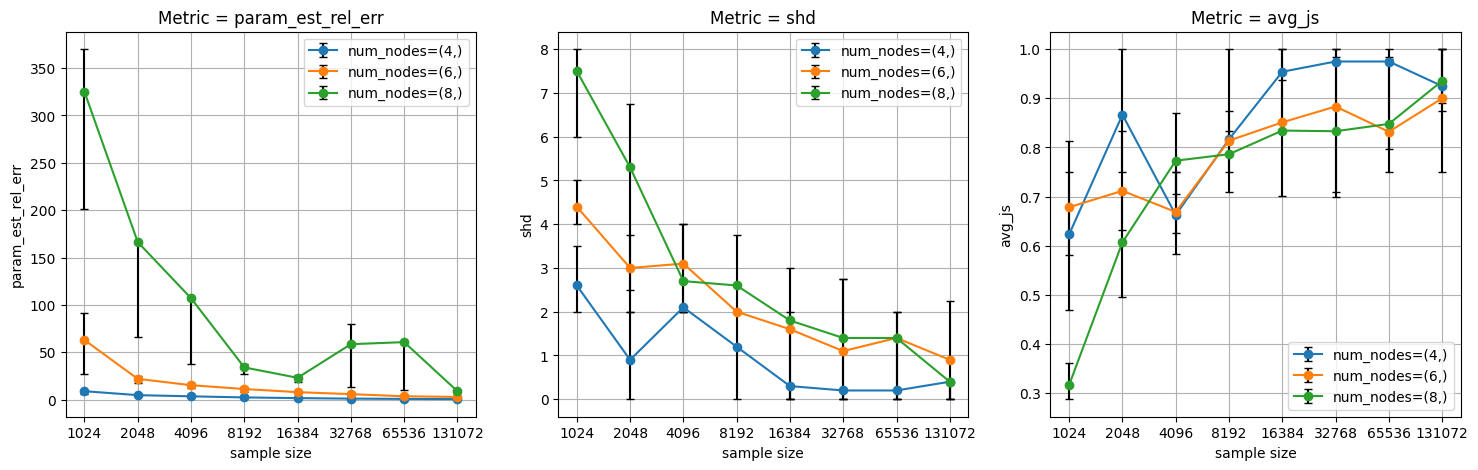

In [16]:
plot_metric_list = ["param_est_rel_err","shd","avg_js"]


plt.rcParams['figure.figsize'] = [6*len(plot_metric_list),5]
fig,ax = plt.subplots(nrows=1,ncols=len(plot_metric_list))


expt_fpath_list= ["expt_logs_29.04.24-11/",]
expt_df = merge_df_multiple_expt(expt_fpath_list)


for num_node,node_df in expt_df.groupby(["num_nodes"]):
    
    #Getting the mean and std for this dataframe
    node_df_mean = node_df.groupby("num_samples").mean()
    node_df_std = node_df.groupby("num_samples").std()
    node_df_q25 = node_df.groupby("num_samples").aggregate(quantile25)
    node_df_q75 = node_df.groupby("num_samples").aggregate(quantile75)
    
    
    #Now plotting the variation across samples for each of the param
    for midx,metric in enumerate(plot_metric_list):
        sample_size = np.array(list(node_df_mean.index))
        metric_mean = np.array(node_df_mean[metric].tolist())
        metric_std = np.array(node_df_std[metric].tolist())
        
        low_yerr = metric_mean - np.array(node_df_q25[metric].tolist())
        high_yerr = np.array(node_df_q75[metric].tolist())-metric_mean
        #CHECK: mean should have been above 25 and below 75, something might be wrong
        q25_75 = [
                    low_yerr*(low_yerr>=0), 
                    high_yerr*(high_yerr>=0)
        ]
        
        
        #ax[midx].plot(range(len(sample_size)),metric_mean,)
        ax[midx].errorbar(range(len(sample_size)),
                              metric_mean,
                              yerr=q25_75,
                              capsize=3,
                              ecolor = "black",
                              fmt="-o",
                              label="num_nodes={}".format(num_node)
        )
        
        ax[midx].set_title("Metric = {}".format(metric))
        ax[midx].set_ylabel(metric)
        ax[midx].set_xlabel("sample size")
        ax[midx].set_xticks(range(len(sample_size)))
        ax[midx].set_xticklabels(sample_size)
        ax[midx].legend()
        ax[midx].grid(True)
        
plt.plot()

In [18]:
'''
TODO:
p : 0.9--1 (number of edges missing)
Can we restrict Chandlers algo?
Our EM (loglikelhood) (later)
Implementing Gaussian PC (read paper Kalisch)
Better perams setting (nodes and other)
Optimal upper bounds for this IGSP
'''

'\np : 0.9--1 (number of edges missing)\nCan we restrict Chandlers algo?\nOur EM (loglikelhood) (later)\nImplementing Gaussian PC (read paper Kalisch)\nBetter perams setting (nodes and other)\nOptimal upper bounds for this IGSP\n'